In [25]:
# 导入numpy库，用于进行科学计算
import numpy as np

# 导入scipy库，用于科学计算和工程计算
import scipy

# 导入matplotlib.pyplot，用于数据可视化
import matplotlib.pyplot as plt

# 导入sympy库，用于符号数学计算
import sympy as sp

一般来说,我们在解线性方程组是有两种办法:直接法和迭代法,在本章中,我们将介绍直接法.

在介绍Gauss消元法之前,我们先介绍一些基础的矩阵知识,我们将用代码来实现.

In [26]:
class matrixOfSteven:
    def __init__(self, a):
        self.array = a
        self.rows = len(a)
        self.columns = len(a[0])
        
    def __add__(self, other):
        if not isinstance(other, matrixOfSteven):
            raise TypeError("加法操作仅支持 matrixOfSteven 类型的对象")
        if self.rows != other.rows or self.columns != other.columns:
            raise ValueError("矩阵相加时，行列数必须相同")
        
        # 利用 NumPy 加法直接在原地修改，避免额外的拷贝操作
        self.array += other.array
        return self
    
    def __mul__(self, other):
        if not isinstance(other, matrixOfSteven):
            raise TypeError("乘法操作仅支持 matrixOfSteven 类型的对象")
        if self.columns != other.rows:
            raise ValueError(f"矩阵相乘时，{self.rows}x{self.columns}矩阵的列数必须等于{other.rows}x{other.columns}矩阵的行数")
        
        result_array = np.dot(self.array, other.array)
        return matrixOfSteven(result_array)
    
    def __eq__(self, other):
        if not isinstance(other, matrixOfSteven):
            return False
        if self.rows != other.rows or self.columns != other.columns:
            return False
        
        for i in range(self.rows):
            for j in range(self.columns):
                if self.array[i, j] != other.array[i, j]:
                    return False
        return True
    
    def __repr__(self) -> str:
        return str(self.array)
    
    def T(self):
        return matrixOfSteven(np.transpose(self.array))

上述例子供演示使用,在实际使用中我们仍然使用计算速度更快且功能更完善的numpy包中的矩阵来实现后续功能

# Gauss消元法简介
Gauss消元法，又称高斯消元法，是一种在数学中广泛应用于解线性方程组的经典算法。该方法由著名数学家卡尔·弗里德里希·高斯命名，是线性代数中解决线性方程组问题的基础工具之一。Gauss消元法通过行变换将线性方程组转化为阶梯形矩阵（也称作行简化形式），进而求得方程组的解。下面是Gauss消元法的基本步骤和概念的Markdown格式介绍：

## 基本概念
* 线性方程组: 形如 $Ax = b$ 的方程组，其中 $A$ 是系数矩阵，$x$ 是未知数向量，$b$ 是常数项向量。
* 增广矩阵: 将系数矩阵 $A$ 和常数项向量 $b$ 组合在一起形成的新矩阵 $[A|b]$。
* 行简化: 通过交换行、倍乘行、加减行等基本行变换操作，使增广矩阵逐步转化为上三角形或阶梯形矩阵的过程。

## Gauss消元法步骤
1. 初始化: 
    构建增广矩阵: 将线性方程组的系数矩阵 $A$ 和常数项向量 $b$ 合并成增广矩阵 $[A|b]$。
2. 消元过程: 
    选择主元素: 对于每一列（从左至右），选择一个非零元素作为该列的“主元素”。理想情况下，选择绝对值最大的元素作为主元素，以减少舍入误差。

3. 行变换: 
    1. 消零: 使用主元素所在行，通过适当的加减操作，将该列下方的所有元素变为0，这一过程称为“消元”。
    2. 比例变换: 如有必要，可以通过乘以一个非零常数来调整行，使得主元素变为1，这有助于简化后续计算。
重复步骤2和3，直至所有非主对角线位置的元素都变为0，形成上三角形矩阵。

4. 回代求解: 
    回代求解: 利用上三角形矩阵，从最后一个方程开始向前，逐步解出未知数。具体来说，先解最后一个方程得到最后一个未知数的值，然后依次向前，利用已解出的未知数解出剩余未知数。

## 特殊情况处理
* 无解或无穷多解: 如果在消元过程中出现某一行全为0（除了最右边的常数项），则需根据常数项判断方程组是否有解。若所有常数项均为0，则方程组有无穷多解；若存在非零常数项，则方程组无解。
* 数值稳定性: 实际计算中，由于浮点运算的精度限制，应尽量避免将很小的数作为除数，以减少数值误差。

In [27]:
def gauss_solve(A_input, b_input, epsilon=1e-15):
    """
    高斯消元法求解方程组的解

    Args:
        A_input (np.ndarray): 输入的系数矩阵，应为方阵
        b_input (np.ndarray): 输入的常数向量,其长度应与A_input的行数或列数相等
        epsilon (float): 用于判断元素是否为0的阈值

    Returns:
        np.ndarray: 方程组的解向量

    Raises:
        ValueError: 当输入的矩阵不是方阵、输入向量的长度与矩阵的行数或列数不匹配、或者出现除零情况时抛出
    """
    
    # 校验输入类型和维度
    A = np.array(A_input).astype(float)
    b = np.array(b_input).astype(float)
    
    if not (A.ndim == 2 and b.ndim == 1):
        raise ValueError("输入的A和b的维度不正确")
    
    n = A.shape[0]
    if n != A.shape[1] or n != len(b):
        raise ValueError("输入的矩阵不是方阵或常数向量长度不匹配")
    
    # 复制矩阵以避免修改原始输入
    A = A.copy()
    b = b.copy()
    
    x = np.zeros_like(b)
    
    for i in range(n-1):
        
        # 检查主元是否接近0
        if np.abs(A[i, i]) < epsilon:
            raise ValueError(f"第{i+1}行第{i+1}列元素接近0,无法消元")
        
        # 高斯消元
        for j in range(i+1, n):
            factor = A[j, i] / A[i, i]
            A[j, :] -= factor * A[i, :]
            b[j] -= factor * b[i]
                
    # 后向 substitution
    for i in range(n-1, -1, -1):
        x[i] = (b[i] - np.dot(A[i, i+1:], x[i+1:])) / A[i, i]
        
    return x

In [28]:
A = np.array([[1, 2, 0], [4, 0, 6], [0, 8, 10]])
b = np.array([1, 2, 3])
x = np.linalg.solve(A, b)
x1 = gauss_solve(A, b)
print(x)
print(x1)

[0.40625  0.296875 0.0625  ]
[0.40625  0.296875 0.0625  ]


In [29]:
def column_main_gauss_elimination(A_in:np.array, b_in:np.array,output_key = False) -> np.array:
    
    """
    Summeration of the column-main Gauss elimination method for solving linear equations:
    采用列主元高斯消元法求解线性方程组
    
    Args:
        A_in (Matrix): 要求方阵
        b_in (Matrix): 要求长度与A_in行数相同的向量
    
    Returns:
        Matrix[]: 求解线性方程组的解向量

    """
    
    A = A_in.copy()
    
    b = b_in.copy()
    
    m = len(A)
    n = len(A[0])
    
    if m!=n:
        return "A is not a square matrix"
    
    x = np.zeros((n,1))
    
    i = 0
    while i < m-1:
        
        column_max = abs(A[i][i])
        column_max_index = i
        
        for j in range(i+1, m):
            
            if abs(A[j][i]) > abs(column_max):
                column_max = A[j][i]
                column_max_index = j
                
        if column_max == 0:
            return "A is singular"
                
        if i != j:
            for k in range(i,m):
            
                A[i][k], A[column_max_index][k] = A[column_max_index][k], A[i][k]
                
            b[i], b[column_max_index] = b[column_max_index], b[i]
            
        
        for j in range(i+1,m):
            
            param = A[j][i]/A[i][i]
            
            for k in range(i,m):
                A[j][k] = A[j][k] - param*A[i][k]
            b[j] = b[j] - param*b[i]
            
        if output_key:
            print(f"Item:{i+1}\nA:{A}\nb:{b}")
         
            
        i+=1
                
        
    x[n-1,0] = b[n-1] / A[n-1][n-1]    
        
    for i in range(m-2,-1,-1):
        t = 0
        for j in range(i+1,n):
            t = t + A[i][j]*x[j,0]
                
        x[i,0] = (b[i] - t) / A[i][i]
        
    return x
            
        

In [30]:

L2 = column_main_gauss_elimination(A, b)

print(L2)

[[ 0.5  ]
 [ 0.375]
 [-0.   ]]


# LU分解介绍
LU分解是线性代数中一种重要的矩阵因式分解方法，广泛应用于数值分析领域，尤其是在解决线性方程组、计算逆矩阵和行列式值等问题上。该方法将一个满秩的方阵$A$分解为一个下三角矩阵$L$和一个上三角矩阵$U$的乘积，即$A = LU$。在某些情况下，为了保证分解过程的顺利进行，还会涉及到一个置换矩阵$P$，这时分解形式变为$PA = LU$，但这不影响基本思想。

## 基本概念
* ### 下三角矩阵(L)：
  主对角线以上的元素全为0，主对角线上的元素通常为1（单位下三角矩阵），其余位置的元素可以是任意实数。

* ### 上三角矩阵(U)：
  主对角线以下的元素全为0，其余位置的元素可以是任意实数。

* ### 置换矩阵(P)：
  由单位矩阵经过行交换得到，作用是对矩阵的行进行重新排序，以确保在进行消元时每一步的主元不为0。

## LU分解过程
1. 初始化：设$A$为$n \times n$的方阵，目标是找到$L$和$U$，使得$A = LU$或$PA = LU$。

2. 消元过程：通过行变换将$A$转换为上三角矩阵$U$，同时记录每次行变换生成的下三角矩阵$L$。具体操作包括选择主元素、消元和更新$L$。

3. 选择主元素：每一步选择当前子矩阵左上角的元素作为主元素，如果该元素为0或接近0，则可能需要进行行交换，这会引入置换矩阵$P$。

4. 消元：对于每个主元素，用它去除下面的列，确保该列下方的元素变为0，这一过程实质上是在构造$U$。

5. 更新$L$：记录每次消元操作的缩放因子，形成$L$的非对角线元素，而$L$的对角线元素通常设为1。

## 应用
* 求解线性方程组：将方程组$Ax = b$转换为两个更简单的方程组$Ly = b$和$Ux = y$，分别求解$y$和$x$。

* 求逆矩阵：一旦得到$L$和$U$，可以通过它们来快速计算原矩阵$A$的逆矩阵。

* 计算行列式：矩阵$A$的行列式等于$L$和$U$的行列式的乘积，而$L$和$U$的行列式又很容易计算，因为它们分别是下三角和上三角矩阵。

## 注意事项
LU分解只适用于方阵，并且要求矩阵为满秩，即行列式不为0。
在实际计算中，由于浮点运算的误差，直接应用高斯消元法可能不会严格得到下三角矩阵$L$，因此通常采用修正的算法，如Crout分解或Doolittle算法，来确保$L$保持单位下三角的形式。

In [31]:
def LU_decomposition(A, b=None, isCompute=False):
    """
    对矩阵A进行LU分解,如果提供了b,则同时解线性方程组Ax = b。
    
    参数:
    A: numpy.ndarray, 输入的系数矩阵，必须是方阵。
    b: numpy.ndarray, 可选,线性方程组的右侧常数向量,必须与A的列数匹配。
    isCompute: bool, 可选，指定是否计算线性方程组的解。
    
    返回:
    tuple: 包含L矩阵、U矩阵和解向量x的元组。如果isCompute为False,x为None。
    """


    # 参数检验
    # 检查A是否为方阵
    if not isinstance(A, np.ndarray) or A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("参数A必须是一个方阵。")
    # 如果提供了b，检查其维度是否与A匹配
    if b is not None and (not isinstance(b, np.ndarray) or A.shape[1] != b.shape[0]):
        raise ValueError("参数b的维度与A的列数不匹配。")
    
    n = len(A)
    
    L = np.zeros((n, n))
    U = np.zeros((n, n))
    
    for i in range(n):
        L[i][i] = 1
        if i == 0:
            U[0][0] = A[0][0]
            for j in range(1, n):
                U[0][j] = A[0][j]
                L[j][0] = A[j][0] / U[0][0]
        else:
            for j in range(i, n):  # 生成U矩阵
                temp = 0
                for k in range(0, i):
                    temp += L[i][k] * U[k][j]
                U[i][j] = A[i][j] - temp
            for j in range(i + 1, n):  # 生成L矩阵
                temp = 0
                for k in range(0, i):
                    temp += L[j][k] * U[k][i]
                L[j][i] = (A[j][i] - temp) / U[i][i]
    
    # 如果需要计算解
    # 数值解算
    if isCompute:
        
        if b is None:
            raise ValueError("当isCompute为True时,必须提供b。")
        
        Z = scipy.linalg.solve(L,b)
        
        x = scipy.linalg.solve(U,Z)
        
        return L, U, x
    
    else:
        
        return L, U, None

In [32]:
A = np.array([[3,1,0],[1,3,1],[0,1,3]]).astype(float)
b = np.array([6,12,9]).astype(float)
L,U,x = LU_decomposition(A,b,True)
print("\nL:\n",L,"\nU:\n",U,"\nx:\n",x)



L:
 [[1.         0.         0.        ]
 [0.33333333 1.         0.        ]
 [0.         0.375      1.        ]] 
U:
 [[3.         1.         0.        ]
 [0.         2.66666667 1.        ]
 [0.         0.         2.625     ]] 
x:
 [1. 3. 2.]


# 施密特正交化与QR分解简介
在数值线性代数中，QR分解是一种将矩阵分解为一个正交矩阵(Q)和一个上三角矩阵(R)的技术，即给定一个矩阵(A)（通常是方阵或可逆矩阵），寻找两个矩阵(Q)和(R)，使得 [ A = QR ] 其中，(Q)是一个正交矩阵，意味着它的列向量是两两正交且单位长度的；(R)是一个上三角矩阵，其对角线元素非负。

`施密特正交化过程`是实现QR分解的一种方法，特别适用于通过迭代方式将一个线性无关的向量集合转换成一组正交向量集。这一过程不仅在理论上有重要意义，而且在数值计算、信号处理、数据压缩、最小二乘问题等领域有着广泛的应用。

## 施密特正交化步骤
假设我们有矩阵(A)的列向量集合${a_1, a_2, ..., a_n}$，施密特正交化过程如下：

1. 正规化第一个向量：取第一个向量$a_1$并将其单位化，得到$q_1 = \frac{a_1}{||a_1||}$。

2. 正交化后续向量：对于每一个后续向量$a_k$($k = 2, 3, ..., n$)：

* 计算它与已获得的所有正交向量$q_1, q_2, ..., q_{k-1}$的投影，即计算 $ p_k = a_k - \sum_{j=1}^{k-1}(a_k^Tq_j)q_j $
* 将得到的向量$p_k$单位化，以得到新的正交向量 $ q_k = \frac{p_k}{||p_k||} $
经过这n步操作后，我们得到了一组正交向量${q_1, q_2, ..., q_n}$，它们构成矩阵$Q$的列向量。

## 构建矩阵(R)
矩阵$R$可以通过记录正交化过程中去除各向量间线性相关的系数来构建。具体地，$R$的第$i$行第$j$列元素（$i \leq j$）等于向量$a_i$在正交基${q_1, q_2, ..., q_j}$中的坐标表示中$q_j$的系数，即 
$$ R_{ij} = \begin{cases} 
    ||a_i|| & \text{if } i=j \\
     (a_i^Tq_j) & \text{if } i < j \\
      0 & \text{otherwise} 
    \end{cases} $$

## 应用
* 最小二乘问题：QR分解可以高效解决最小二乘问题，通过将原问题转化为上三角系统求解。
* 数值稳定性：在某些情况下，相比于其他分解方法，QR分解提供了更高的数值稳定性。
* 特征值问题：作为更复杂算法的一部分，用于计算矩阵的特征值和特征向量。

我们将QR分解分为以下两个步骤:
1. 求解Q(Orthogonal Matrix):\
对于矩阵$A_{m \times n}$,我们要求其列满秩,此时,我们一定可以对$A$做列正交化:
   1. 将$A$划分为$(a_1,\cdots,a_n)$
   2. 将$a$正交化,得到$b$,$$ b_1 = a_1,\\ b_i = a_i - \sum_{j=1}^{i-1} \frac{\langle b_j,a_i \rangle}{\langle b_j,b_j \rangle}b_j$$

   3. 将$b$单位化为$u$,得到$Q$

$$
Q = \begin{bmatrix}
u_1 ,u_2, \cdots ,u_n
\end{bmatrix}
$$
2. 求解R(Upper Triangular Matrix):\
我们分解的目的是将$A$分解为$QR$的形式,因此,在我们得到$Q$后,也就得到了$R$,$R = Q^T A$
$$


In [33]:
def QR_decomposition(A):
    """
    对矩阵A进行QR分解。
    
    QR分解是一种将矩阵分解为一个正交矩阵和一个上三角矩阵的方法。
    此函数用于计算给定矩阵A的QR分解,其中Q是正交矩阵,R是上三角矩阵。
    
    参数:
    A: 二维numpy数组,待分解的方阵
    
    返回值:
    Q: 二维numpy数组,正交矩阵
    R: 二维numpy数组,上三角矩阵
    
    异常:
    ValueError: 如果输入矩阵A不是方阵或为空矩阵,则抛出此异常
    RuntimeError: 如果矩阵A在分解过程中出现奇异情况,则抛出此异常
    """
    
    # 检查输入矩阵A是否是方阵
    if A.shape[0] != A.shape[1]:
        raise ValueError("输入矩阵A必须是方阵")
    
    # 检查输入矩阵A是否为空矩阵
    if A.size == 0:
        raise ValueError("输入矩阵A不能为空矩阵")
    
    # 初始化Q为与A相同形状的零矩阵，R为None
    Q = np.zeros_like(A)
    R = None
    
    # 初始化计数器cnt，用于跟踪已处理的列数
    cnt = 0
    # 遍历A的转置的每一列，进行QR分解
    for a in A.T:
        # 复制当前列a，用于后续计算
        u = np.copy(a)
        # 逐个减去已计算的Q的列向量与当前列a的内积乘以Q的列向量，得到u
        for i in range(cnt):
            u -= np.dot(np.dot(Q[:, i].T, a), Q[:, i])
        
        # 计算u的范数，用于正常化
        # 处理可能出现的除以0的情况
        norm_u = np.linalg.norm(u)
        # 如果u的范数为0，说明矩阵A奇异，抛出异常
        if norm_u == 0:
            raise RuntimeError("矩阵A可能是奇异的,无法进行QR分解")
        
        # 将u正常化得到e，作为Q的新的列向量
        e = u / norm_u
        Q[:, cnt] = e
        cnt += 1
    
    # 通过Q的转置乘以A得到R，完成QR分解
    # 仅当A不是奇异矩阵时，才能成功进行QR分解
    R = np.dot(Q.T, A)
    
    # 返回Q和R
    return Q, R

In [34]:
q,r = QR_decomposition(A)

print("QR分解为:\nQ\n",q,"\nR\n",r)
print(np.dot(q,r))

QR分解为:
Q
 [[ 0.9486833  -0.29408585  0.11624764]
 [ 0.31622777  0.88225755 -0.34874292]
 [ 0.          0.36760731  0.92998111]] 
R
 [[ 3.16227766e+00  1.89736660e+00  3.16227766e-01]
 [ 2.22044605e-16  2.72029410e+00  1.98507948e+00]
 [-1.11022302e-16 -1.11022302e-16  2.44120041e+00]]
[[ 3.00000000e+00  1.00000000e+00  1.11575007e-16]
 [ 1.00000000e+00  3.00000000e+00  1.00000000e+00]
 [-2.16234239e-17  1.00000000e+00  3.00000000e+00]]


# Cholesky分解:
当我们遇到对称正定矩阵时,LU分解可以拥有一个更加简单的形式,那就是Cholesky分解.  
即 将对称正定阵$A$分解为$A=LDL^T$

我们给予一个简单的证明:  
`Proof`:  
假设$A$的顺序主子式均大于0,此时我们由LU分解可知矩阵`A`可以分解为$LDU_0$
其中
$$
L = \begin{pmatrix}
    1 \\
    l_1 & 1\\
    l_2 & l_3 & 1\\
    \vdots & \vdots & \ddots & \vdots\\
    l_{n-1} & l_n & \dots & l_{n-1}
    \end{pmatrix}

D = \begin{pmatrix}
    d_1 & 0 & 0 & \dots & 0\\
    0 & d_2 & 0 & \dots & 0\\
    0 & 0 & d_3 & \dots & 0\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    0 & 0 & 0 & \dots & d_n
    \end{pmatrix}

U_0 = \begin{pmatrix}
    1 & u_{12}/u_{11} & u_{13}/u_{11} & \dots & u_{1n}/u_{11}\\
    0 & 1 & u_{23}/u_{22} & \dots & u_{2n}/u_{22}\\
    0 & 0 & 1 & \dots & u_{3n}/u_{33}\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    0 & 0 & 0 & \dots & 1
    \end{pmatrix}
$$
,因为`A`为对称矩阵,有$A^T = A$,因此可知$U_0^T(DL)^T = LDU_0$,由分解唯一性可知$U_0^T = L$,  
由此,我们知道$A = LDL^T$,证明完毕.

## 基本性质
* 下三角矩阵：分解得到的矩阵 $L$ 是下三角矩阵，即除了主对角线及左下方的元素外，其余元素均为零。
* 对角元非负：$L$ 的对角元素都是正数，这是因为原矩阵 $A$ 的正定性保证了其所有顺序主子式的值也为正。
* 计算效率：相比一般的LU分解，Cholesky分解由于只涉及下三角矩阵，计算上更为高效，特别是在解决大型稀疏线性方程组和求解多元正态分布等问题时。
* 存在性和唯一性：对于每一个实对称正定矩阵，Cholesky分解都是存在且唯一的。

同时我们可以由上述分析导出对称正定矩阵方程组的一种求解方法

In [35]:
def Cholesky_decomposition(A):
    
    """
    对矩阵做改进的无需开平方的Cholesky分解
    """
    
    
    w = A.shape[0]
    
    L = np.zeros((w,w))
    
    for i in range(w):
        L[i,i] = 1
        
    D = np.zeros((w,w))
    
    for i in range(w):
        D[i,i] = A[i,i] - np.dot(np.dot(L[i,:i],D[:i,:i]),L[i,:i].T)
        for j in range(i+1,w):
            L[j,i] = (A[j,i] - np.dot(np.dot(L[j,:i],D[:i,:i]),L[i,:i].T))/D[i,i]
            
    return L,D

In [36]:
L,D = Cholesky_decomposition(np.dot(A.T,A))
L1,D1,_ = LU_decomposition(np.dot(A.T,A))

print("L:\n",L,"\nD:\n",D)
print(L@D@L.T)
print("L1:\n",L1,"\nD1:\n",D1)
print(L1@D1)

L:
 [[1.         0.         0.        ]
 [0.6        1.         0.        ]
 [0.1        0.72972973 1.        ]] 
D:
 [[10.          0.          0.        ]
 [ 0.          7.4         0.        ]
 [ 0.          0.          5.95945946]]
[[10.  6.  1.]
 [ 6. 11.  6.]
 [ 1.  6. 10.]]
L1:
 [[1.         0.         0.        ]
 [0.6        1.         0.        ]
 [0.1        0.72972973 1.        ]] 
D1:
 [[10.          6.          1.        ]
 [ 0.          7.4         5.4       ]
 [ 0.          0.          5.95945946]]
[[10.  6.  1.]
 [ 6. 11.  6.]
 [ 1.  6. 10.]]


In [37]:
def Cholesky_solve(A, b, output_key = False):
    A = A.copy()
    b = b.copy()
    
    L,D = Cholesky_decomposition(A)
    
    w = len(A)
    
    y = np.zeros(w)
    y[0] = b[0]
    
    for i in range(1,w):
        y[i] = b[i] - sum(L[i,:i]*y[:i])
        
        
    x = np.zeros(w)
    x[w-1] = y[w-1]/D[w-1,w-1]
    for i in range(w-2,-1,-1):
        x[i] = (y[i] - sum(L[i+1:,i]*x[i+1:]))/D[i,i]
        
    if output_key:
        return L,D,x
    else:
        return x
    

In [38]:
L,D,x_cholesky = Cholesky_solve(np.dot(A.T,A),[1,5,3],output_key=True)

print(f"L矩阵为:\n{L},\nD矩阵为:\n{D},\n解向量为:\n{x}")


L矩阵为:
[[1.         0.         0.        ]
 [0.6        1.         0.        ]
 [0.1        0.72972973 1.        ]],
D矩阵为:
[[10.          0.          0.        ]
 [ 0.          7.4         0.        ]
 [ 0.          0.          5.95945946]],
解向量为:
[1. 3. 2.]


# 追赶法
## 引言
追赶法（又称托马斯算法，Thomas Algorithm）是一种高效求解三对角线性方程组的数值方法，尤其适用于那些来源于有限差分方法的矩阵问题。它本质上是对这类特殊结构矩阵进行LU分解的一种简化形式，能够避免直接使用高斯消元法时的冗余计算，显著提高计算效率。

## 原理
### 矩阵结构
追赶法主要应用于形如以下三对角线性方程组的求解： 
$$ 
\begin{pmatrix} 
    b_1 & c_1 & 0 & \cdots & 0 \\ 
    a_2 & b_2 & c_2 & \ddots & \vdots \\
    0 & a_3 & b_3 & \ddots & 0 \\
    \vdots & \ddots & \ddots & \ddots & c_{n-1} \\
    0 & \cdots & 0 & a_n & b_n 
\end{pmatrix} 

\begin{pmatrix} 
    x_1 \\
    x_2 \\ 
    x_3 \\
    \vdots \\
    x_n
\end{pmatrix}
     = 
\begin{pmatrix} 
    d_1 \\ 
    d_2 \\ 
    d_3 \\ 
    \vdots \\
    d_n 
\end{pmatrix} 
$$

## 步骤概述
1. 初始化: 设 $y_1 = d_1 / b_1$，这是第一个变量的临时解。
2. 向前追赶（Forward Sweep）: 对于 $i = 2, 3, ..., n$，计算临时变量 $y_i$ 和修改后的系数 $b_i'$ 如下：
    $$ b_i' = b_i - \frac{a_i}{b_{i-1}}c_{i-1}, \quad y_i = \frac{d_i - a_iy_{i-1}}{b_i'} $$
     这一步骤实质上是在进行LU分解中的`消元`阶段。
3. 向后追赶（Backward Sweep）: 利用 $y_i$ 计算最终解 $x_n, x_{n-1}, ..., x_1$： 
    $$ x_n = y_n, \quad x_i = y_i - \frac{c_i}{b_{i+1}}x_{i+1} ,\text{ for } i = n-1, n-2, ..., 1 $$ 
    向后过程相当于利用上三角矩阵求解。

In [39]:
def ThomasDecomposition(d, a=0, b=0, c=0, A_in=[], isMatrix=False, output_key=False):
    """
    Thomas算法:用于解三对角线矩阵的线性方程组。
    
    参数:
    d: 底线的系数列表。
    a: 上下对角线的系数列表,默认为0。
    b: 中对角线的系数列表,默认为0。
    c: 上对角线的系数列表,默认为0。
    A_in: 直接输入三对角线矩阵A,默认为空列表。
    isMatrix: 指示是否直接使用矩阵A_in,默认为False。
    output_key: 是否返回辅助系数列表c_1和d_1,默认为False。
    
    返回:
    x: 线性方程组的解列表。
    或者:
    x, c_1, d_1: 如果output_key为True,则返回解列表x以及辅助系数列表c_1和d_1。
    """
    
    # 确定三对角线矩阵的大小
    n = len(d)    

    # 根据isMatrix参数决定是创建一个新的矩阵还是使用输入的矩阵
    if not isMatrix:
        # 创建一个零矩阵并根据a, b, c参数初始化
        A = np.zeros((n, n)).astype(float)
        for i in range(n):
            A[i, i] = b
            if i > 0:
                A[i, i - 1] = a
            if i < n - 1:
                A[i, i + 1] = c
    else:
        # 直接使用输入的矩阵
        A = A_in.copy()

    # 初始化辅助系数列表
    c_1 = [0] * n
    d_1 = [0] * n

    # 计算辅助系数c_1和d_1
    for i in range(n):
        if not i:
            c_1[i] = c / b
            d_1[i] = d[i] / b
        else:
            c_1[i] = c / (b - c_1[i - 1] * a)
            d_1[i] = (d[i] - d_1[i - 1] * a) / (b - c_1[i - 1] * a)

    # 初始化解的列表
    x = [0] * n

    # 逆序遍历，使用Thomas算法计算解
    for i in range(n - 1, -1, -1):
        if i == n - 1:
            x[i] = d_1[i]
        else:
            x[i] = d_1[i] - c_1[i] * x[i + 1]

    # 对解进行四舍五入，确保精度
    x = [round(_, 4) for _ in x]

    # 根据output_key参数决定返回结果
    if output_key:
        return x, c_1, d_1
    else:
        return x

In [40]:
##书面作业第3题(ex10)

A = np.array(
    [
        [2,-1,1],
        [-1,-2,-3],
        [1,-3,1]
    ]
).astype(float)

b = np.array(
    [4,5,6]
    ).astype(float)

L_ex3,D_ex3,x_ex3 = Cholesky_solve(A,b,output_key=True)

print(f"L:\n{L_ex3}\nD:\n{D_ex3}\nx:\n{x_ex3}")

L:
[[ 1.   0.   0. ]
 [-0.5  1.   0. ]
 [ 0.5  1.   1. ]]
D:
[[ 2.   0.   0. ]
 [ 0.  -2.5  0. ]
 [ 0.   0.   3. ]]
x:
[ 1.45 -3.2  -1.  ]


In [41]:
##书面作业第一题(课本ex7)

A_ex1 = np.array(
    [
    [12,-3,3],
    [-18,3,-1],
    [1,1,1]
    ]
).astype(float)

b_ex1 = np.array(
    [
    [15],
    [-15],
    [6]
    ]
).astype(float)

L_ex1 = column_main_gauss_elimination(A_ex1, b_ex1,True)

print(L_ex1)

Item:1
A:[[-18.           3.          -1.        ]
 [  0.          -1.           2.33333333]
 [  0.           1.16666667   0.94444444]]
b:[[-15.        ]
 [-25.        ]
 [  5.16666667]]
Item:2
A:[[-18.           3.          -1.        ]
 [  0.           1.16666667   0.94444444]
 [  0.           0.           3.14285714]]
b:[[-15.        ]
 [  5.16666667]
 [  9.5952381 ]]
[[0.98989899]
 [1.95707071]
 [3.0530303 ]]


In [42]:
##书面作业第2题(ex9)

a,b,c = -1,2,-1
d = np.zeros(5)
d[0] = 1

x_ex2,beta_ex2,y_ex2 = ThomasDecomposition(d,a,b,c,output_key=True)

print(f"beta:{beta_ex2},x_ex2:{x_ex2},y_ex2:{y_ex2}")

beta:[-0.5, -0.6666666666666666, -0.7499999999999999, -0.8, -0.8333333333333334],x_ex2:[0.8333, 0.6667, 0.5, 0.3333, 0.1667],y_ex2:[0.5, 0.3333333333333333, 0.24999999999999997, 0.19999999999999998, 0.16666666666666666]


ex1:  
对下列5对角阵进行LU分解,并计算该过程需要的乘除法次数
$$
A = \begin{pmatrix}
    35 & -16 & 1 & 0 & 0 & \cdots & 0\\
    -16 & 35 & -16 & 1 & 0 & \cdots & 0\\
    1 & -16 & 35 & -16 & 1 & \cdots & 0\\
    0 & 1 & -16 & 35 & -16 & \cdots & 0\\
    0 & 0 & 1 & -16 & 35 & \cdots & 0\\
    \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots\\
    0 & 0 & 0 & 0 & 0 & \cdots & 35
\end{pmatrix}_{n*n}
$$


In [43]:
n = 5 ##假设为5阶矩阵

A = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        if abs(i-j) == 1:
            A[i,j] = -16
        elif abs(i-j) == 2:
            A[i,j] = 1
        elif i == j:
            A[i,j] = 35
        else:
            A[i,j] = 0
            
print(A)

L,U,_ = LU_decomposition(A)

print("LU分解结果为:\nL\n",L,"\nU\n",U)

[[ 35. -16.   1.   0.   0.]
 [-16.  35. -16.   1.   0.]
 [  1. -16.  35. -16.   1.]
 [  0.   1. -16.  35. -16.]
 [  0.   0.   1. -16.  35.]]
LU分解结果为:
L
 [[ 1.          0.          0.          0.          0.        ]
 [-0.45714286  1.          0.          0.          0.        ]
 [ 0.02857143 -0.56140351  1.          0.          0.        ]
 [ 0.          0.03611971 -0.58823529  1.          0.        ]
 [ 0.          0.          0.0381016  -0.59545455  1.        ]] 
U
 [[ 35.         -16.           1.           0.           0.        ]
 [  0.          27.68571429 -15.54285714   1.           0.        ]
 [  0.           0.          26.24561404 -15.43859649   1.        ]
 [  0.           0.           0.          25.88235294 -15.41176471]
 [  0.           0.           0.           0.          25.78489305]]


ex2:  
利用追赶法计算三对角矩阵$Ax = b$,$n = 15$;并画出向量$x$的图像
$$
A = 
    \begin{pmatrix}
      2 & -1 &  &  &  &  \\
      -1 & 2 &  &  &  &  \\
       &  & \ddots &  &  &  \\
       &  &  &  & 2 & -1 \\
       &  &  &  & -1 & 2
    \end{pmatrix}_{n*n}

x = \begin{pmatrix}
    x_1 \\ x_2 \\ \vdots \\ x_{n-1} \\ x_n
    \end{pmatrix}_{n*1}

b = \begin{pmatrix}
    1 \\ 0 \\ \vdots \\ 0 \\ 0
    \end{pmatrix}_{n*1}
    
$$
$$

15
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.9375, 0.875, 0.8125, 0.75, 0.6875, 0.625, 0.5625, 0.5, 0.4375, 0.375, 0.3125, 0.25, 0.1875, 0.125, 0.0625]


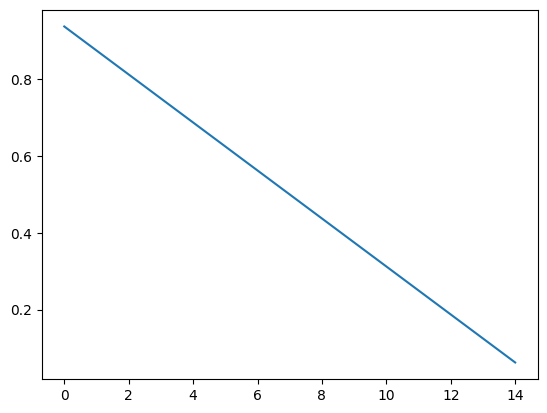

In [44]:
b = np.zeros(15)

print(len(b))
b[0] = 1
print(b)

x = ThomasDecomposition(b,-1,2,-1)

index = np.arange(15)

plt.plot(index,x)

print(x)

ex3:  
对矩阵A进行LU分解以及QR分解;并对$A^TA$进行Cholesky分解;
$$
A = \begin{pmatrix}
    8 & -3 & 2 \\
    4 & 11 & -1 \\
    6 & 3 & 12 
    \end{pmatrix}
$$

In [45]:
A = np.array([[8,-3,2], [4, 11, -1], [6, 3, 12]]).astype(float)

B = A.T@A
print("A生成的正定矩阵为:\n",B)

L,U,_ = LU_decomposition(A)

Q,R = QR_decomposition(A)

LCho,D = Cholesky_decomposition(B)

print("其LU分解为:\nL\n",L,"\nU\n",U,"\n")
print("其QR分解为:\nQ\n",Q,"\nR\n",R,"\n","\nQ与R乘积为:\n",np.dot(Q,R))

print("其cholesky分解为:\nL\n",LCho,"\nD\n",D,"\n")


A生成的正定矩阵为:
 [[116.  38.  84.]
 [ 38. 139.  19.]
 [ 84.  19. 149.]]
其LU分解为:
L
 [[1.   0.   0.  ]
 [0.5  1.   0.  ]
 [0.75 0.42 1.  ]] 
U
 [[ 8.   -3.    2.  ]
 [ 0.   12.5  -2.  ]
 [ 0.    0.   11.34]] 

其QR分解为:
Q
 [[ 0.74278135 -0.49963813 -0.44568779]
 [ 0.37139068  0.86133935 -0.34664606]
 [ 0.55708601  0.09195794  0.82534775]] 
R
 [[ 1.07703296e+01  3.52821143e+00  7.79920420e+00]
 [ 8.32667268e-17  1.12495211e+01 -7.57120355e-01]
 [-1.11022302e-15 -1.11022302e-16  9.35944350e+00]] 
 
Q与R乘积为:
 [[ 8. -3.  2.]
 [ 4. 11. -1.]
 [ 6.  3. 12.]]
其cholesky分解为:
L
 [[ 1.          0.          0.        ]
 [ 0.32758621  1.          0.        ]
 [ 0.72413793 -0.06730245  1.        ]] 
D
 [[116.           0.           0.        ]
 [  0.         126.55172414   0.        ]
 [  0.           0.          87.59918256]] 



# 向量与矩阵范数笔记

在数学和数值分析领域，向量和矩阵范数是衡量向量或矩阵大小的重要工具，它们在理论分析和实际计算中扮演着关键角色。下面将详细介绍向量与矩阵范数的概念、性质及其应用。

## 向量范数
### 定义
向量范数提供了一种量化向量长度或大小的方法。形式上，对于一个复数或实数向量空间 $\mathbb{C}^n$ 或 $\mathbb{R}^n$ 中的向量 $x$，向量范数 $|x|$ 必须满足以下性质：

* 非负性：$||x|| \geq 0$，且 $||x|| = 0$ 当且仅当 $x = 0$。
* 齐次性：对于任意标量 $k$，有 $||kx|| = |k| ||x||$。
* 三角不等式：对于任意向量 $x, y$，有 $||x + y|| \leq ||x|| + ||y||$。

### 常见向量范数
* 1范数（曼哈顿范数）：$||x||_1 = \sum_{i=1}^n |x_i|$。
* 2范数（欧几里得范数）：$||x||_2 = \sqrt{\sum_{i=1}^n |x_i|^2}$。
* p范数：$||x||_p = \left(\sum_{i=1}^n |x_i|^p\right)^{1/p}$。
* $\infty$范数（最大范数）：$||x||_{\infty} = \max_{i=1}^n |x_i|$。

## 矩阵范数
### 定义
矩阵范数是对矩阵作为线性映射的规模进行度量，它不仅考虑了矩阵元素的大小，还考虑了矩阵运算的效果。形式上，对于一个 $m \times n$ 矩阵 $A$，矩阵范数 $||A||$ 必须满足：

* 非负性：$||A|| \geq 0$，且 $||A|| = 0$ 当且仅当 $A$ 是零矩阵。
* 齐次性：对于任意标量 $k$，有 $||kA|| = |k| ||A||$。
* 三角不等式：对于任意矩阵 $A, B$，有 $||A + B|| \leq ||A|| + ||B||$。
* 子空间不等式：对于任意 $m \times p$ 矩阵 $B$，有 $||AB|| \leq ||A|| ||B||$。
* 等距性：对于任意向量 $x$，有 $||Ax|| \leq ||A|| ||x||$。

### 常见矩阵范数
* **Frobenius 范数**：$||A||_F = \sqrt{\sum_{i=1}^m \sum_{j=1}^n |a_{ij}|^2}$，类似于向量的2范数。
* 谱范数（2范数）：$||A||_2 = \sigma_{\max}(A)$，等于矩阵的最大奇异值。
* 最大行范数：$||A||_{\max} = \max_{i=1}^m \sum_{j=1}^n |a_{ij}|$。
* 最大列范数：另一种表述形式，对应于向量$\infty$范数。

## 相容性与从属范数
矩阵范数和向量范数之间存在相容性关系，即如果矩阵范数 $||\cdot||_M$ 与向量范数 $||\cdot||_V$ 相容，那么对于任意矩阵 $A$ 和向量 $x$，有 $||Ax||_V \leq ||A||_M ||x||_V$。从属范数就是一种由向量范数诱导出的矩阵范数，例如，矩阵的2范数（谱范数）就是由向量的2范数诱导出来的。

# 矩阵条件数
在数值线性代数中，矩阵条件数是一个衡量线性方程组或矩阵运算对输入数据的敏感性的指标。它反映了矩阵在数值计算中稳定性的程度，尤其是在面对舍入误差时。条件数大的矩阵表示微小的输入变化可能导致输出结果发生较大的变化，从而使得问题的数值解变得不稳定。

## 定义
对于一个方阵 $A$ 和其对应的线性方程组 $Ax = b$，矩阵的条件数通常定义为其范数的比值，具体有两种常见的定义：

* 相对条件数（谱条件数）：记作 $k(A)$ 或 $\kappa(A)$，定义为 $A$ 的最大特征值与最小非零特征值的比值，若 $A$ 是对称正定矩阵，则有 $k(A) = \frac{\lambda_{\max}(A)}{\lambda_{\min}(A)}$，其中 $\lambda_{\max}(A)$ 和 $\lambda_{\min}(A)$ 分别是 $A$ 的最大和最小特征值。

* 条件数（基于范数的）：对于任意两个一致的矩阵范数 $||\cdot||_v$ 和 $||\cdot||_v$，矩阵 $A$ 的条件数定义为 $\kappa_v(A) = ||A||_v \cdot ||A^{-1}||_v$。\
常见的有基于2-范数的条件数，即 $\kappa_2(A) = \sigma_{\max}(A) / \sigma_{\min}(A)$，其中 $\sigma_{\max}(A)$ 和 $\sigma_{\min}(A)$ 分别是 $A$ 的最大和最小奇异值。

## 性质
* 对于任意非奇异矩阵$A$而言,都有$1 \leq cond_v{(A)}$ 
* 矩阵的条件数具有齐次性
* 如果$A$为正交矩阵,则其2-条件数$cond_2(A) = 1$,且有非奇异矩阵$A$,正交矩阵$R$
  $$
  cond_2(RA) = cond_2(AR) = cond_2(A)
  $$

## 重要性
* 数值稳定性：条件数揭示了矩阵在数值求解过程中的稳定性。当条件数较大时，即使微小的输入变化也可能导致解的巨大波动，这表明该问题在数值上是不稳定的。
* 误差放大：在数值计算中，由于舍入误差的存在，条件数高的矩阵会显著放大这些误差，影响计算结果的精度。
算法选择与设计：了解矩阵的条件数有助于选择或设计更稳健的算法来解决特定问题，特别是在求解线性方程组、矩阵逆、特征值等问题时。
## 影响因素
* 矩阵结构：对称正定矩阵、稀疏矩阵等具有特殊结构的矩阵往往具有更好的条件数，而接近奇异的矩阵（如秩亏缺矩阵）则条件数较高。
* 数据尺度：数据的尺度变化会影响矩阵的条件数。通过适当的规范化或预处理可以改善条件数。
## 改善方法
* 预处理：通过矩阵的正则化、归一化等预处理手段可以改善条件数。
* 重新参数化：在某些情况下，重新选择问题的参数表示可以降低条件数。
* 迭代方法：对于条件数大的问题，使用迭代方法（如共轭梯度法）可能比直接求解方法（如高斯消元法）更为有效，因为迭代法可以在每一步都考虑误差的影响。
## 总结
矩阵条件数是衡量线性问题数值稳定性的重要指标，它指导我们如何理解和应对数值计算中的误差放大问题。在实际应用中，合理评估和改善矩阵条件数是确保算法准确性和效率的关键步骤之一。


In [48]:
x = np.linspace(0.1,0.17,8)
y = [42,43,45,45,45,47,49,53]

t1 = sum(x)
t2 = sum(x ** 2)
t4 = sum(y)
t5 = sum(x * y)

A = np.array([
    [1,t1],
    [t1,t2]
]).astype(float)


b = np.array([
    t4,t5
]).astype(float)

k = gauss_solve(A,b)

k

array([ -0.9244392 , 342.52262889])